# Оценка результатов AB тестирования

Используя данные интернет-магазина, произвести оценку результатов A/B-тестирования. Предоставлены данные интернет-магазина, содержащие информацию о покупках пользователей в период с 2019-08-01 по 2019-08-31. Необходимо сравнить группы по метрикам - количество заказов на пользователя и величине среднего чека.

## Цели исследования 

Принять решение по результатам теста из следующих вариантов:

1. Остановить тест, зафиксировать победу одной из групп;
2. Остановить тест, зафиксировать отсутствие различий между группами;
3. Продолжить тест.

### Изучение и предобработка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt 
import math as mth
from scipy import stats as st
import re
import datetime as dt

sns.set()

In [2]:
#чтение датасетов
orders, visitors = (
    pd.read_csv(r'C:\Users\User\My Jupyter Projects\ABtest\orders.csv'), #заказы
    pd.read_csv(r'C:\Users\User\My Jupyter Projects\ABtest\visitors.csv')  #пользователи
)

In [3]:
for i in [orders, visitors]:
    display(i.info())
    display(i.head(5))
    display(i.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


0

In [4]:
#функция для стилистического приведение столбцов
def to_snake(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

In [5]:
#стилистическое приведение столбцов
orders.columns = [to_snake(x) for x in orders.columns.values]

In [6]:
#чек
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [7]:
#преобразуем даты в объект datetime для таблицы orders
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [8]:
#преобразуем даты в объект datetime для таблицы visitors
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


In [9]:
#чек
for i in [orders, visitors]:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

Пропусков нет, столбцы приведены к snake_case, даты преобразованы в объект datetime.

### Проверка корректности групп 

In [10]:
#проверка корректности дат и литер в группах
temp = pd.DataFrame({'min': [visitors.date.min(), orders.date.min()], 'max': [visitors.date.max(), orders.date.max()], \
                     'group_name': [orders.group.unique(), visitors.group.unique()]})
temp.index = ['visitors', 'orders']
temp

,min,max,group_name
visitors,2019-08-01,2019-08-31,"[B, A]"
orders,2019-08-01,2019-08-31,"[A, B]"


Временные промежутки, литеры обозначений групп в датасетах visitors и orders - корректены.

In [11]:
#проверка пользователей на принадлежность двум группам
d_users = orders.groupby('visitor_id').agg({'group':'nunique'})
d_users = d_users[d_users['group'] > 1]
d_users.count()

group    58
dtype: int64

58 пользователей имеют принадлежность к группам A и B одновременно. Для изоляции групп и получении более достоверных результатов, этих пользователей необходимо удалить.

In [12]:
#удаление пользователей принадлежащих двум группам
orders = orders.query('visitor_id not in @d_users.index')

In [13]:
#чек
test = orders.groupby('visitor_id').agg({'group':'nunique'})
test = test[test['group'] > 1]
test.count()

group    0
dtype: int64

Группы пользователей частично изолированы, потому как нельзя удалить пользователей, принадлежащим обеим группам из таблицы visitors

In [14]:
#количество посетителей и количество покупателей по группам
temp2 = pd.DataFrame(
    {'A': [visitors[visitors['group']=='A']['visitors'].sum(), orders[orders['group']=='A']['visitor_id'].count()],  
     'B': [visitors[visitors['group']=='B']['visitors'].sum(), orders[orders['group']=='B']['visitor_id'].count()]}
)
temp2.index = ['visitors', 'orders']
temp2

,A,B
visitors,18736,18916
orders,468,548


Группы пользователей не равны.

### Построение графика кумулятивной выручки по группам

In [15]:
orders.head(1)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


In [16]:
#сгруппируем заказы
orders_grooped = orders.groupby(['date', 'group']).agg({'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'})
#чек
orders_grooped.head(2)

transaction_id  visitor_id  revenue
date       group                                     
2019-08-01 A                  23          19   142779
           B                  17          17    59758

In [17]:
visitors.head(1)

,date,group,visitors
0,2019-08-01,A,719


In [18]:
#сгруппируем посетителей
visitors_grooped = visitors.groupby(['date', 'group']).agg({'visitors':'sum'})
#чек
visitors_grooped.head(2)

visitors
date       group          
2019-08-01 A           719
           B           713

In [19]:
#объединим таблицы
data_grouped = orders_grooped.merge(visitors_grooped, left_index=True, right_index=True)
#чек
data_grouped.head(2)

transaction_id  visitor_id  revenue  visitors
date       group                                               
2019-08-01 A                  23          19   142779       719
           B                  17          17    59758       713

In [20]:
#расчет кумулятивных значений
cumulative_data =(
    data_grouped.groupby('group')[['transaction_id','visitor_id','revenue', 'visitors']]).cumsum().reset_index()
#переименуем столбцы
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
#чек
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,37,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,61,346854,1845


In [21]:
#разделение по группам (A)
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A'].reset_index()
#чек
cumulative_data_A.head(3)

,index,date,group,orders,buyers,revenue,visitors
0,0,2019-08-01,A,23,19,142779,719
1,2,2019-08-02,A,42,37,234381,1338
2,4,2019-08-03,A,66,61,346854,1845


In [22]:
#разделение по группам (B)
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B'].reset_index()
#чек
cumulative_data_B.head(3)

,index,date,group,orders,buyers,revenue,visitors
0,1,2019-08-01,B,17,17,59758,713
1,3,2019-08-02,B,40,39,221801,1294
2,5,2019-08-03,B,54,53,288850,1803


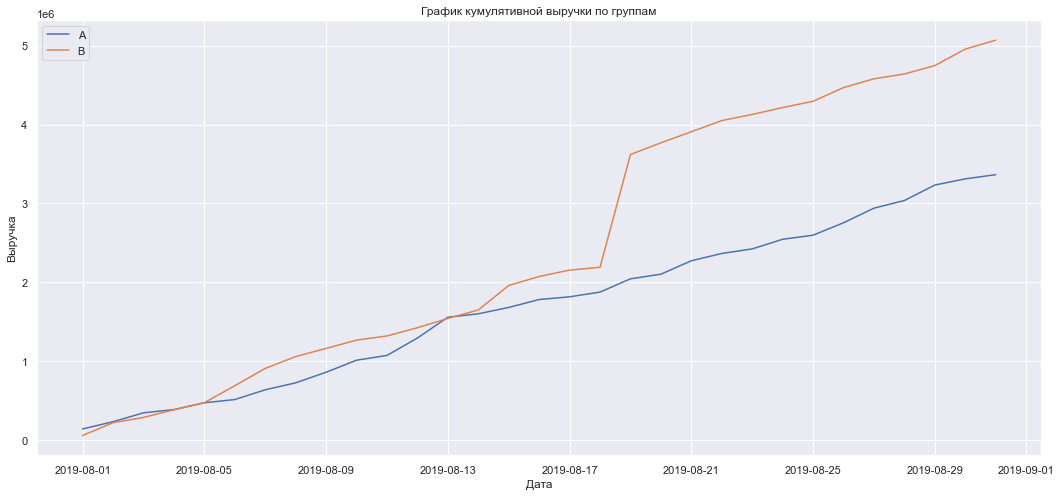

In [23]:
#задание размеров
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График кумулятивной выручки по группам')
# построение графика выручки группы А
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'], label='A')
# построение графика выручки группы B
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'], label='B')
#задание подписи
plt.xlabel('Дата')
plt.ylabel('Выручка')
#сетка
plt.grid(True)
#легенда
plt.legend()
plt.show()

####  Выводы

В целом, группа В показывает лучшие показатели выручки, относительно группы А. 

Выручка группы А равномерно растет на протяжении всего теста. Выручка группы В показывает равномерный рост до момента 2019-08-18. В этой точке наблюдается большой скачок, что может быть вызвано рядом причин, такими как:

- удачно запущенной промо-акцией, что в свою очередь привело к увеличению числа заказов;
- увеличению 'среднего чека';
- аномальными заказами.

После скачка графика, в группе В наблюдается стабильный рост показателя. 

### Построение графика кумулятивного среднего чека по группам

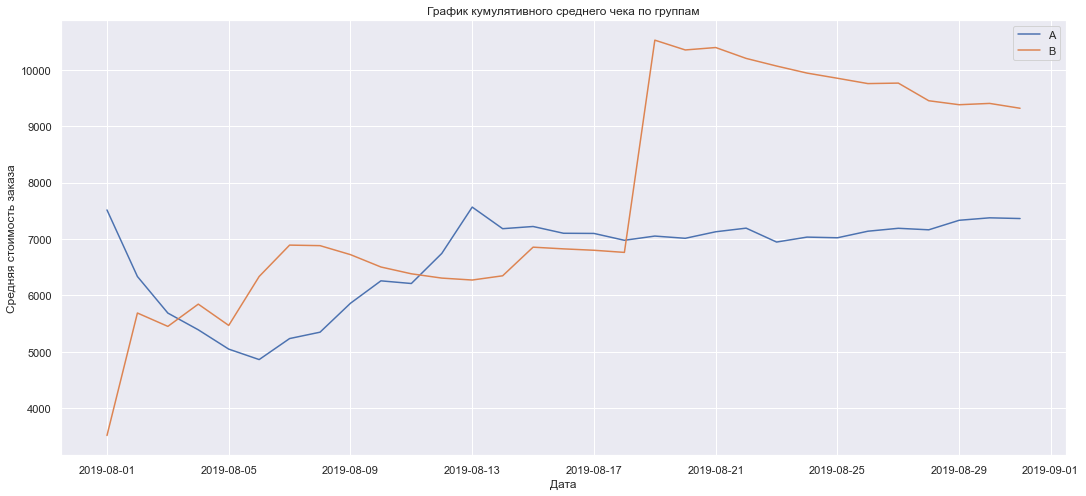

In [24]:
#задание размеров
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График кумулятивного среднего чека по группам')
# построение графика выручки группы А
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'] / cumulative_data_A['buyers'], label='A')
# построение графика выручки группы B
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'] / cumulative_data_B['buyers'], label='B')
#задание подписи
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость заказа')
#сетка
plt.grid(True)
#легенда
plt.legend();

#### Выводы

До середины теста показатели кумулятивного среднего чека для обеих групп колебались. Однако, как и на графике кумулятивной выручки, наблюдается скачок группы B на моменте 2019-08-18, далее график демонстрирует снижение показателя. Учитывая, что вырос и средний чек и выручка, можно судить, что на резкий скачок повлиял один или несколько аномально высоких заказа. 

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

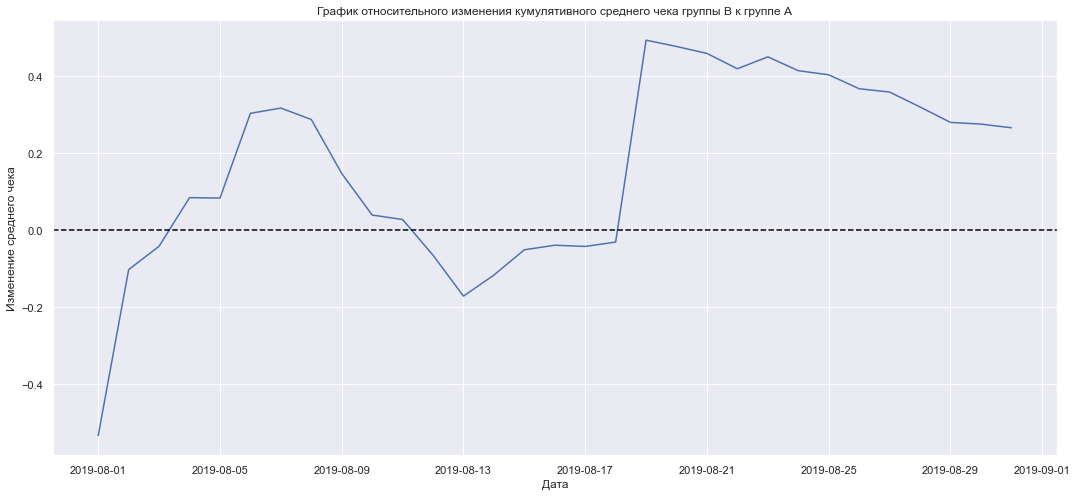

In [25]:
#задание размеров
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А')
# построение отношения средних чеков
plt.plot(cumulative_data_A['date'], ((cumulative_data_B['revenue'] / cumulative_data_B['buyers']) / \
                                     (cumulative_data_A['revenue'] / cumulative_data_A['buyers'])-1))
#задание подписи
plt.xlabel('Дата')
plt.ylabel('Изменение среднего чека')
#сетка
plt.grid(True)
#добавление оси
plt.axhline(y=0, color='black', linestyle='--');

#### Выводы

К середине теста, отношение среднего чека группы B к группе A, показывало отрицательную динамику. Далее график показал резкий скачок, очевидно из-за аномальных заказов, после чего наметилось снижение.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

In [26]:
cumulative_data_A.head(1)

,index,date,group,orders,buyers,revenue,visitors
0,0,2019-08-01,A,23,19,142779,719


In [27]:
#добавление слотбца отношения заказов к посетителям для группы А
cumulative_data_A['avg_ord'] = (cumulative_data_A.orders / cumulative_data_A.visitors)*100
#чек
cumulative_data_A.head(5)

,index,date,group,orders,buyers,revenue,visitors,avg_ord
0,0,2019-08-01,A,23,19,142779,719,3.198887
1,2,2019-08-02,A,42,37,234381,1338,3.139013
2,4,2019-08-03,A,66,61,346854,1845,3.577236
3,6,2019-08-04,A,77,72,388030,2562,3.005464
4,8,2019-08-05,A,99,94,474413,3318,2.983725


In [28]:
#добавление слотбца отношения заказов к посетителям для группы B
cumulative_data_B['avg_ord'] = (cumulative_data_B.orders / cumulative_data_B.visitors)*100
#чек
cumulative_data_B.head(5)

,index,date,group,orders,buyers,revenue,visitors,avg_ord
0,1,2019-08-01,B,17,17,59758,713,2.384292
1,3,2019-08-02,B,40,39,221801,1294,3.091190
2,5,2019-08-03,B,54,53,288850,1803,2.995008
3,7,2019-08-04,B,68,66,385740,2573,2.642829
4,9,2019-08-05,B,89,87,475648,3280,2.713415


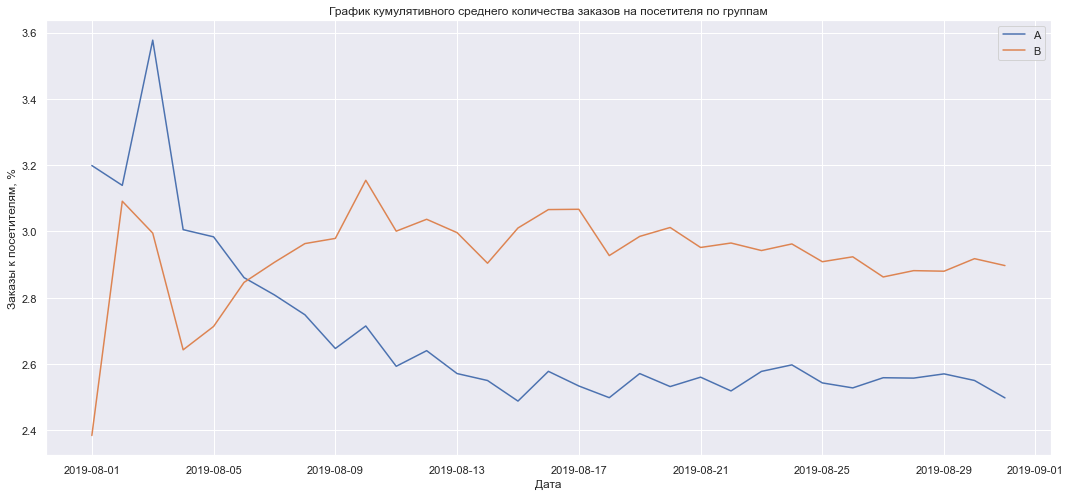

In [29]:
#построение графика
#задание размеров
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
# построение графика выручки группы А
plt.plot(cumulative_data_A['date'], cumulative_data_A['avg_ord'], label='A')
# построение графика выручки группы B
plt.plot(cumulative_data_B['date'], cumulative_data_B['avg_ord'], label='B')
#задание подписи
plt.xlabel('Дата')
plt.ylabel('Заказы к посетителям, %')
#сетка
plt.grid(True)
#легенда
plt.legend();

#### Выводы

Практически на протяжении всего теста значения в группе B выше. Это может быть обусловлено увеличением числа заказов в группе B. Группа A, напротив, продемонстрировав скачок вначале теста, но уже после 3го дня, начала резкое снижение показателя. 

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

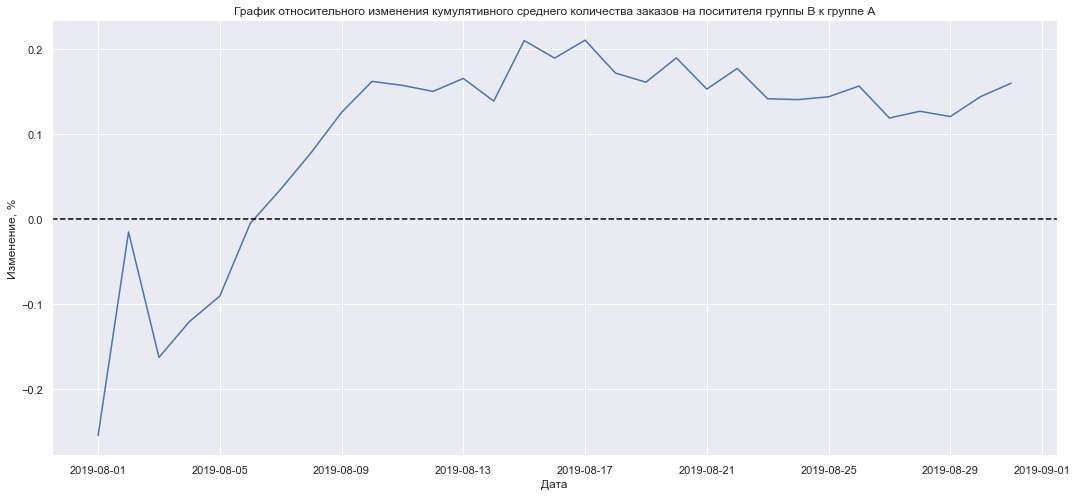

In [30]:
#задание размеров
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График относительного изменения кумулятивного среднего количества заказов на поситителя группы В к группе А')
# построение отношения кумулятивного среднего количества заказов на посетителя группы B к группе A
plt.plot(cumulative_data_A['date'], (cumulative_data_B['avg_ord'] / cumulative_data_A['avg_ord'] - 1))
#задание подписи
plt.xlabel('Дата')
plt.ylabel('Изменение, %')
#сетка
plt.grid(True)
#добавление оси
plt.axhline(y=0, color='black', linestyle='--');

#### Выводы

Практически с самого начала, показатель группы B - заметно выше, порядка 15%. 

### Построение точечного графика количества заказов по пользователям

In [31]:
orders.head(1)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


In [32]:
#группировка количества заказов на пользователя
customers_grouped = orders.groupby('visitor_id').agg({'transaction_id':'nunique'}).reset_index()
#переименование столбцов
customers_grouped.columns = ['customer', 'orders']
#чек
customers_grouped.sort_values(by='orders', ascending=False).head(3)

,customer,orders
908,3967698036,3
55,249864742,3
478,2108163459,3


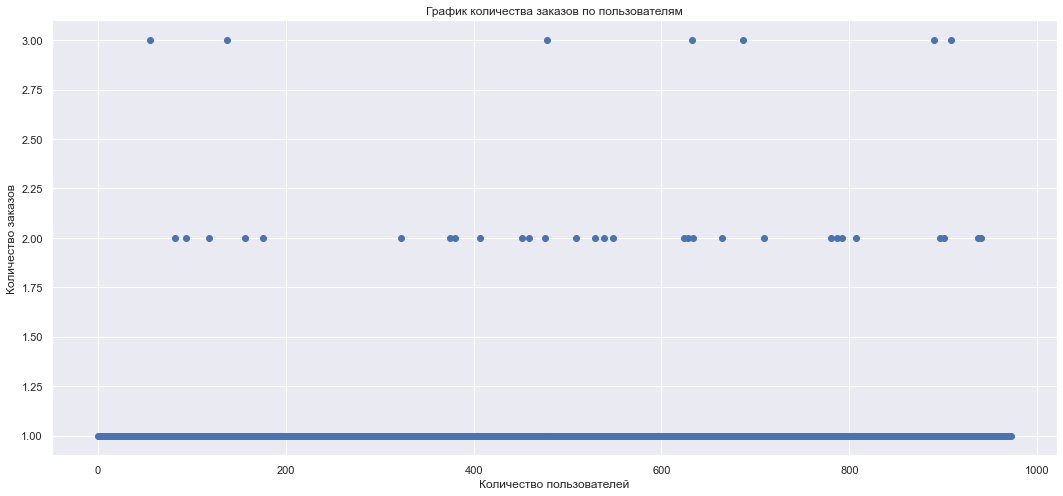

In [33]:
#задание размера
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График количества заказов по пользователям')
#пар-ры графика
x_values = pd.Series(range(0, len(customers_grouped)))
plt.scatter(x_values, customers_grouped['orders'])
#задание подписи
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
#сетка
plt.grid(True)

#### Выводы

Наибольшее число пользователей совершили 1 заказ. Возможно значение в 3 заказа - является аномальным.

### Расчет 95-й и 99-й перцентилей количества заказов на пользователя

In [34]:
#расчет 95го и 99го перцентиля
np.percentile(customers_grouped.orders, [95, 99])

array([1., 2.])

#### Выводы

Расчет показывает, что среди покупателей 95% совершают 1 заказ, 99% - 2 заказа. Следовательно, 3 заказа можно считать аномальным.

### Построение точечного графика стоимостей заказов

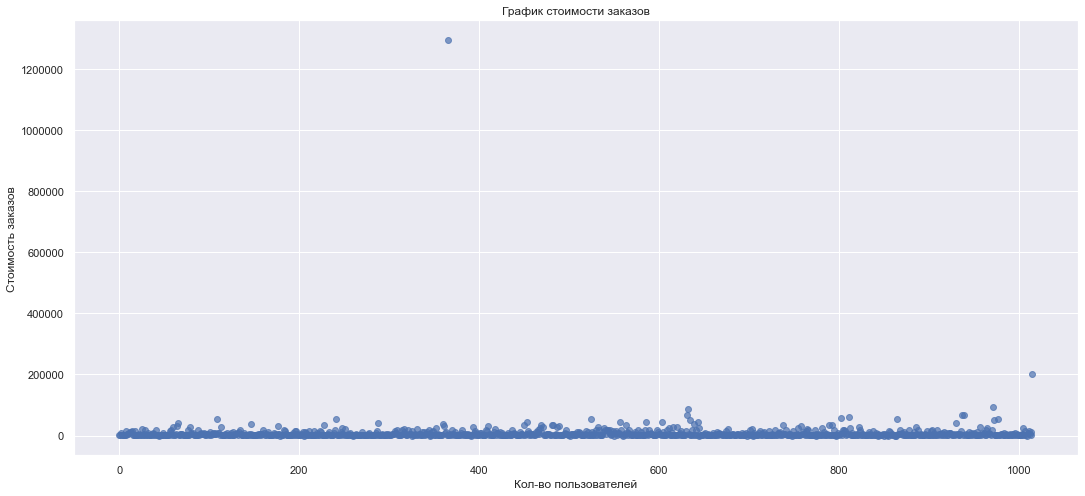

In [35]:
#задание размера
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График стоимости заказов')
#пар-ры графика
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.7)
#задание подписей
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказов')
#сетка
plt.grid(True)
#форматирование оси "y"
plt.ticklabel_format(axis='y', style='plain');

На графике явно видны 2 аномальных значения. Необходимо исключить эти значения для получения более однородной картины.

In [36]:
#чек
orders[orders['revenue']> 200000]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


In [37]:
#исключение аномальных значений
re_orders = orders[orders['revenue'] < 200000]

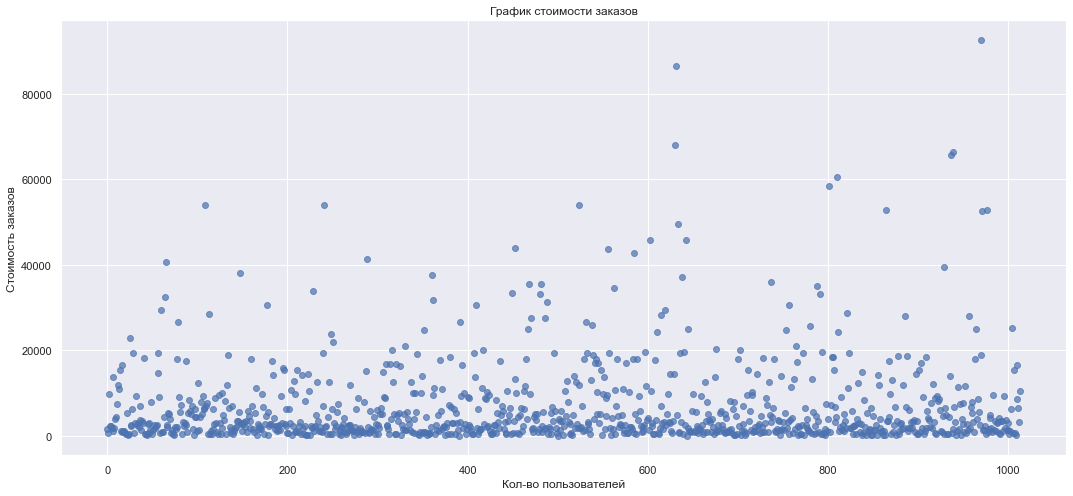

In [38]:
#задание размера
plt.figure(figsize=(18,8))
#задание заголовка
plt.title('График стоимости заказов')
#пар-ры графика
x_values = pd.Series(range(0,len(re_orders['revenue'])))
plt.scatter(x_values, re_orders['revenue'], alpha=0.7)
#задание подписей
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказов')
#сетка
plt.grid(True)
#форматирование оси "y"
plt.ticklabel_format(axis='y', style='plain');

### Расчет 95-й и 99-й перцентилей стоимости заказов

In [39]:
#расчет 95го и 99го перцентиля
np.percentile(orders.revenue, [95, 99])

array([26785., 53904.])

#### Выводы

Расчёт перцентелей говорит, что выбросами можно считать заказы, превышающие стоимость в 53904.

### Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Для расчета статистической значимости будет использован непараметрический тест Уилкоксона-Манна-Уитни.

In [40]:
#разделение клиентов по группам 
#группа A
orders_visitor_a = orders.query('group == "A"').groupby('visitor_id').agg({'transaction_id':'nunique'}).reset_index()
orders_visitor_a.columns = ['customer','order']
orders_visitor_a.head(3)

,customer,order
0,11685486,1
1,54447517,1
2,66685450,1


In [41]:
#группа B
orders_visitor_b = orders.query('group == "B"').groupby('visitor_id').agg({'transaction_id':'nunique'}).reset_index()
orders_visitor_b.columns = ['customer','order']
orders_visitor_b.head(3)

,customer,order
0,5114589,1
1,6958315,1
2,39475350,1


In [42]:
#добавление к числу заказов для группы A списка равной по длине числу послетителей, замена NaN на 0
sample_raw_a = (
    (orders_visitor_a['order'] + 
    pd.Series(0,range(visitors.query('group=="A"')['visitors'].sum()))).fillna(0))
sample_raw_a.to_frame().head(3)

,0
0,1.0
1,1.0
2,1.0


In [43]:
#добавление к числу заказов для группы B списка равной по длине числу послетителей, замена NaN на 0
sample_raw_b = (
    (orders_visitor_b['order'] + 
    pd.Series(0,range(visitors.query('group=="B"')['visitors'].sum()))).fillna(0))
sample_raw_b.to_frame().head(3)

,0
0,1.0
1,1.0
2,1.0


Расчёт статистической значимости предполагает формулировку нулевой и альтернативной гипотез:

H0 - Нет статистически значимых различий среднего количества заказов на пользователя между группами A и B.

H1 -  Есть статистически значимые различия среднего количества заказов на пользователя между группами A и B.

Уровень значимости - 5%.

In [44]:
#задание уровня значимости
alpha=0.05

#проведение теста
p_value = st.mannwhitneyu(sample_raw_a, sample_raw_b)[1]

#анализ результатов
if p_value < alpha:
    print(
        'Минимальный уровень значимости по сырым данным: {:.3f}, нулевая гипотеза отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего количества заказов на пользователя группы B к группе A: {:.2%}'
        .format(sample_raw_b.mean() / sample_raw_a.mean() - 1)
    )
else:
    print(
        'Минимальный уровень значимости по сырым данным:: {:.3f}, нулевая гипотеза не может быть отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего количества заказов на пользователя группы B к группе A: {:.2%}'
        .format(sample_raw_b.mean() / sample_raw_a.mean() - 1)
    )

Минимальный уровень значимости по сырым данным: 0.006, нулевая гипотеза отвергнута
Относительный прирост среднего количества заказов на пользователя группы B к группе A: 15.98%


#### Выводы

Количество заказов распределено в группах неравномерно. Прирост группы B к группе A составил 15.98%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Формулировка гипотез:

H0 - Нет статистически значимых различий в среднем чеке между группами.

H1 - Есть статистически значимые различия в среднем чеке между группами.

In [45]:
#проведение теста
p_value = st.mannwhitneyu(orders[orders['group'] =='A']['revenue'], orders[orders['group'] =='B']['revenue'])[1]

#анализ результатов
if p_value < alpha:
    print(
        'Минимальный уровень значимости при оценке отфильтрованных данных: {:.3f}, нулевая гипотеза отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего чека заказа группы B к группе A: {:.2%}'
        .format(orders[orders['group'] =='B']['revenue'].mean() / orders[orders['group'] =='A']['revenue'].mean() - 1)
    )
else:
    print(
        'Минимальный уровень значимости при оценке отфильтрованных данных: {:.3f}, нулевая гипотеза не может быть отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего чека заказа группы B к группе A: {:.2%}'
        .format(orders[orders['group'] =='B']['revenue'].mean() / orders[orders['group'] =='A']['revenue'].mean() - 1)
    )

Минимальный уровень значимости при оценке отфильтрованных данных: 0.415, нулевая гипотеза не может быть отвергнута
Относительный прирост среднего чека заказа группы B к группе A: 28.66%


#### Выводы

Статистически значимые различия в свреднем чеке между группами отсутствуют.

### Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по очищенным данным

В пункте 2.9.1 было определено количество заказов - 3 - как аномальное. 

In [46]:
#выборка с заказами меньше 3 для группы А
sample_filtered_a = (
    (orders_visitor_a.query('order < 3')['order'] + 
    pd.Series(0,range(visitors.query('group=="A"')['visitors'].sum()))).fillna(0))
sample_filtered_a.to_frame().head(3)

,0
0,1.0
1,1.0
2,1.0


In [47]:
#чек
sample_filtered_a.unique()

array([1., 2., 0.])

In [48]:
#выборка с заказами меньше 3 для группы B
sample_filtered_b = (
    (orders_visitor_b.query('order < 3')['order'] + 
    pd.Series(0,range(visitors.query('group=="B"')['visitors'].sum()))).fillna(0))
sample_filtered_b.to_frame().head(3)

,0
0,1.0
1,1.0
2,1.0


In [49]:
#чек
sample_filtered_b.unique()

array([1., 0., 2.])

Cформированные ранее гипотезы:

H0 - Нет статистически значимых различий среднего количества заказов на пользователя между группами A и B.

H1 - Есть статистически значимые различия среднего количества заказов на пользователя между группами A и B.

Уровень значимости - 5%.

In [50]:
#задание уровня значимости
alpha=0.05

#проведение теста
p_value = st.mannwhitneyu(sample_filtered_a, sample_filtered_b)[1]

#анализ результатов
if p_value < alpha:
    print(
        'Минимальный уровень значимости по сырым данным: {:.3f}, нулевая гипотеза отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего количества заказов на пользователя группы B к группе A: {:.2%}'
        .format(sample_filtered_b.mean() / sample_filtered_a.mean() - 1)
    )
else:
    print(
        'Минимальный уровень значимости по сырым данным:: {:.3f}, нулевая гипотеза не может быть отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего количества заказов на пользователя группы B к группе A: {:.2%}'
        .format(sample_filtered_b.mean() / sample_filtered_a.mean() - 1)
    )

Минимальный уровень значимости по сырым данным: 0.004, нулевая гипотеза отвергнута
Относительный прирост среднего количества заказов на пользователя группы B к группе A: 18.51%


#### Выводы

После фильтрации данных, нулевая гипотеза также отвергнута, относительный прирост увеличился с 15.98% до 18.51%, т.е. группа B показала прирост среднего количества заказов на 18.51%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

В п. 2.11.1 определено, что граница аномальных заказов составляет 53904.

Формулировка гипотез:

H0 - Нет статистически значимых различий в среднем чеке между группами.

H1 - Есть статистически значимые различия в среднем чеке между группами.

In [51]:
#проведение теста
p_value = st.mannwhitneyu(orders.query('group == "A" and revenue < 53904')['revenue'], orders.query('group == "B" and revenue < 53904')['revenue'])[1]

#анализ результатов
if p_value < alpha:
    print(
        'Минимальный уровень значимости при оценке отфильтрованных данных: {:.3f}, нулевая гипотеза отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего чека заказа группы B к группе A: {:.2%}'
        .format(orders.query('group == "B" and revenue < 53904')['revenue'].mean() / orders.query('group == "A" and revenue < 53904')['revenue'].mean() - 1)
    )
else:
    print(
        'Минимальный уровень значимости при оценке отфильтрованных данных: {:.3f}, нулевая гипотеза не может быть отвергнута'
        .format(p_value)
    )
    print(
        'Относительный прирост среднего чека заказа группы B к группе A: {:.2%}'
        .format(orders.query('group == "B" and revenue < 53904')['revenue'].mean() / orders.query('group == "A" and revenue < 53904')['revenue'].mean() - 1)
    )

Минимальный уровень значимости при оценке отфильтрованных данных: 0.477, нулевая гипотеза не может быть отвергнута
Относительный прирост среднего чека заказа группы B к группе A: -1.39%


#### Выводы

Статистически значимые различия в свреднем чеке между группами отсутствуют. 

## Общий вывод

По результатам исследования получены следующие данные:


Число заказов по очищенным данным в группе B увеличилось относительно группы A на 18.51% при отсутствии ститистически значимой разницы в показателе среднего чека, следовательно можно сделать вывод, что группа B является победителем. 

Тест следует остановить.

Вызывает вопросы наличие одних и тех же пользователей в двух группах. Следовательно, пользователи в группах не изолированы, что ставит под сомнение валидность результатов исследования. 